In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from joblib import dump, load

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Sklearn imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
# old classification metrics
from sklearn.metrics import ( classification_report, confusion_matrix, 
                             precision_score, accuracy_score, 
                             precision_recall_fscore_support )
# new classification metrics
from sklearn.metrics import make_scorer, roc_curve 

# Decision tree visualization
#!pip install graphviz
import graphviz

In [2]:
#from google.colab import drive, files
#drive.mount('/content/drive')

In [3]:
#cd "/content/drive/My Drive/UFPA/Healthsense/"

## Introduzindo os dados

In [2]:
step_1 = pd.read_csv('challenge_raw_everyone.csv')
step_2 = pd.read_csv('challenge_processed_everyone.csv')
step_3 = pd.read_csv('challenge_cleaned_everyone.csv')
step_4 = pd.read_csv('challenge_cleaned_everyone.csv')

## Custom scorer based on the False Acceptance Rate and False Rejection Rate

False Acceptance rate:

Number acceptance of impostors / total number of impostors

False Rejection rate:

Number rejected of impostors / total number of impostors


### Source of information:
### https://www.recogtech.com/en/knowledge-base/security-level-versus-user-convenience 
### https://stackoverflow.com/questions/28339746/equal-error-rate-in-python

## Passo 1: Treino sem modificações aos dados originais

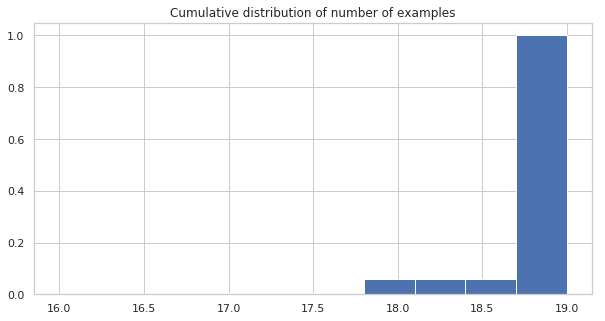

In [5]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution of number of examples")
step_1['person'].value_counts(ascending=True).hist(cumulative=True, density=1)

In [6]:
min_n_of_segments = 17
mask = step_1['person'].value_counts() < min_n_of_segments
people_to_remove = list(mask[mask].index)

for person in people_to_remove:
    step_1 = step_1[step_1.person != person]

In [7]:
original_columns = ['mean_q', 'mean_r', 'mean_s', 'stdev_q', 'stdev_r','stdev_s',
                   'mean_rr_interval', 'mean_rq_amplitude', 'mean_qrs_interval']

X_step_1 = step_1[original_columns]
# Preenche os dados faltosos com a média da respectiva coluna
X_step_1 = X_step_1.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y_step_1 = step_1['person']
X_train_step_1, X_test_step_1, y_train_step_1, y_test_step_1 = train_test_split(X_step_1, y_step_1, stratify=y_step_1,
                                                                                test_size = 0.2, random_state=42)

### New training scheme

In [8]:
rf_step_1 = RandomForestClassifier(n_estimators=120, min_samples_leaf=5, min_samples_split=12, max_depth=100)
ovr_step_1 = OneVsRestClassifier(estimator=rf_step_1, n_jobs=-1)

# train
ovr_step_1.fit(X_train_step_1, y_train_step_1)

# predict probabilites
probabilities_step_1 = ovr_step_1.predict_proba(X_test_step_1)
prob_df_step_1 = pd.DataFrame(probabilities_step_1)
prob_df_step_1.to_csv('probabilities_step_1.csv')

# predict classes
predictions_step_1 = ovr_step_1.predict(X_test_step_1)

# save classification metrics
cm = confusion_matrix(y_test_step_1, predictions_step_1)
cr = classification_report(y_test_step_1, predictions_step_1, output_dict=True)

cr_df = pd.DataFrame(cr).transpose()
cr_df.to_csv('classification_report_1.csv')

cm_df = pd.DataFrame(cm)
cm_df.to_csv('confusion_matrix_1.csv')

# dump the model
dump(ovr_step_1, 'one_vs_rest_classifier_step_1.joblib')

/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['one_vs_rest_classifier_step_1.joblib']

## Passo 2: Treino com adição de segmentos gerados aleatoriamente

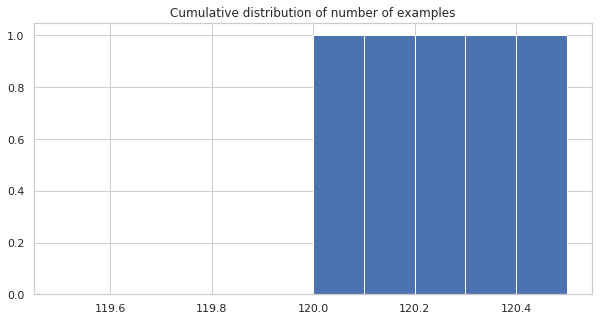

In [9]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution of number of examples")
step_2['person'].value_counts(ascending=True).hist(cumulative=True, density=1)

In [10]:
#le_step_2 = LabelEncoder()
#step_2['person'] = pd.Series(le_step_2.fit_transform(step_2['person']))
original_columns = ['mean_q', 'mean_r', 'mean_s', 'stdev_q', 'stdev_r','stdev_s',
                   'mean_rr_interval', 'mean_rq_amplitude', 'mean_qrs_interval']

X_step_2 = step_2[original_columns]
# Preenche os dados faltosos com a média da respectiva coluna
X_step_2 = X_step_2.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y_step_2 = step_2['person']

X_train_step_2, X_test_step_2, y_train_step_2, y_test_step_2 = train_test_split(X_step_2, y_step_2, stratify=y_step_2,
                                                                                test_size = 0.2, random_state=42)

In [11]:
rf_step_2 = RandomForestClassifier(n_estimators=120, min_samples_leaf=5, min_samples_split=12, max_depth=100)
ovr_step_2 = OneVsRestClassifier(estimator=rf_step_2, n_jobs=-1)

# train
ovr_step_2.fit(X_train_step_2, y_train_step_2)

# predict probabilites
probabilities_step_2 = ovr_step_2.predict_proba(X_test_step_2)
prob_df_step_2 = pd.DataFrame(probabilities_step_2)
prob_df_step_2.to_csv('probabilities_step_2.csv')

# predict classes
predictions_step_2 = ovr_step_2.predict(X_test_step_2)

# save classification metrics
cm = confusion_matrix(y_test_step_2, predictions_step_2)
cr = classification_report(y_test_step_2, predictions_step_2, output_dict=True)

cr_df = pd.DataFrame(cr).transpose()
cr_df.to_csv('classification_report_2.csv')

cm_df = pd.DataFrame(cm)
cm_df.to_csv('confusion_matrix_2.csv')

# dump the model
dump(ovr_step_2, 'one_vs_rest_classifier_step_2.joblib')

['one_vs_rest_classifier_step_2.joblib']

## Passo 3: Treino com adição de segmentos gerados aleatoriamente e remoção de outliers

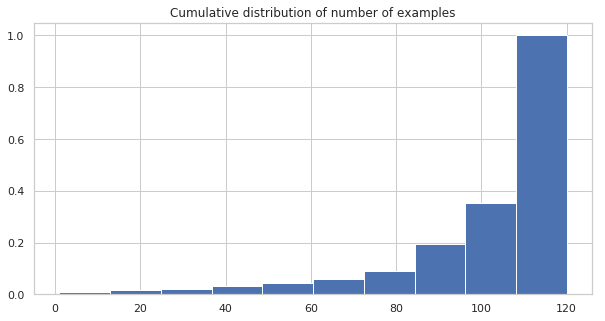

In [12]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution of number of examples")
step_3['person'].value_counts(ascending=True).hist(cumulative=True, density=1)

In [13]:
## Remove pessoas que tem menos que 60 segmentos
min_n_of_segments = 60
mask = step_3['person'].value_counts() < min_n_of_segments
people_to_remove = list(mask[mask].index)
for person in people_to_remove:
    step_3 = step_3[step_3.person != person]

In [14]:
#le_step_3 = LabelEncoder()
#step_3['person'] = pd.Series(le_step_3.fit_transform(step_3['person']))
original_columns = ['mean_q', 'mean_r', 'mean_s', 'stdev_q', 'stdev_r','stdev_s',
                   'mean_rr_interval', 'mean_rq_amplitude', 'mean_qrs_interval']

X_step_3 = step_3[original_columns]
# Preenche os dados faltosos com a média da respectiva coluna
X_step_3 = X_step_3.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y_step_3 = step_3['person']

X_train_step_3, X_test_step_3, y_train_step_3, y_test_step_3 = train_test_split(X_step_3, y_step_3, stratify=y_step_3,
                                                                                test_size = 0.2, random_state=42)
print(f'Há {y_train_step_3.nunique()} classes únicas no conjunto de TREINO')
print(f'Há {y_test_step_3.nunique()} classes únicas no conjunto de TESTE')

Há 1890 classes únicas no conjunto de TREINO
Há 1890 classes únicas no conjunto de TESTE


In [ ]:
rf_step_3 = RandomForestClassifier(n_estimators=120, min_samples_leaf=5, min_samples_split=12, max_depth=100)
ovr_step_3 = OneVsRestClassifier(estimator=rf_step_3, n_jobs=-1)

# train
ovr_step_3.fit(X_train_step_3, y_train_step_3)

# predict probabilites
probabilities_step_3 = ovr_step_3.predict_proba(X_test_step_3)
prob_df_step_3 = pd.DataFrame(probabilities_step_3)
prob_df_step_3.to_csv('probabilities_step_3.csv')

# predict classes
predictions_step_3 = ovr_step_3.predict(X_test_step_3)

# save classification metrics
cm = confusion_matrix(y_test_step_3, predictions_step_3)
cr = classification_report(y_test_step_3, predictions_step_3, output_dict=True)

cr_df = pd.DataFrame(cr).transpose()
cr_df.to_csv('classification_report_3.csv')

cm_df = pd.DataFrame(cm)
cm_df.to_csv('confusion_matrix_3.csv')

# dump the model
dump(ovr_step_3, 'one_vs_rest_classifier_step_3.joblib')

## Passo 4: Todas as features, segmentos aleatórios e remoção de outliers 

In [3]:
## Remove pessoas que tem menos que 60 segmentos
min_n_of_segments = 60
mask = step_4['person'].value_counts() < min_n_of_segments
people_to_remove = list(mask[mask].index)

for person in people_to_remove:
    step_4 = step_4[step_4.person != person]

In [5]:
#le_step_4 = LabelEncoder()
#step_5['person'] = pd.Series(le_step_4.fit_transform(step_5['person']))

X_step_4 = step_4.drop('person', axis=1)
# Preenche os dados faltosos com a média da respectiva coluna
X_step_4 = X_step_4.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y_step_4 = step_4['person']

X_train_step_4, X_test_step_4, y_train_step_4, y_test_step_4 = train_test_split(X_step_4, y_step_4, stratify=y_step_4,
                                                                                test_size=0.2, random_state=42)
print(f'Há {y_train_step_4.nunique()} classes únicas no conjunto de TREINO')
print(f'Há {y_test_step_4.nunique()} classes únicas no conjunto de TESTE')

Há 1890 classes únicas no conjunto de TREINO
Há 1890 classes únicas no conjunto de TESTE


In [ ]:
rf_step_4 = RandomForestClassifier(n_estimators=120, min_samples_leaf=5, min_samples_split=12, max_depth=100)
ovr_step_4 = OneVsRestClassifier(estimator=rf_step_4, n_jobs=-1)

# train
ovr_step_4.fit(X_train_step_4, y_train_step_4)

# predict probabilites
probabilities_step_4 = ovr_step_4.predict_proba(X_test_step_4)
prob_df_step_4 = pd.DataFrame(probabilities_step_4)
prob_df_step_4.to_csv('probabilities_step_4.csv')

# predict classes
predictions_step_4 = ovr_step_4.predict(X_test_step_4)

# save classification metrics
cm = confusion_matrix(y_test_step_4, predictions_step_4)
cr = classification_report(y_test_step_4, predictions_step_4, output_dict=True)

cr_df = pd.DataFrame(cr).transpose()
cr_df.to_csv('classification_report_4.csv')

cm_df = pd.DataFrame(cm)
cm_df.to_csv('confusion_matrix_4.csv')

# dump the model
dump(ovr_step_4, 'one_vs_rest_classifier_step_4.joblib')

## Single decision tree  




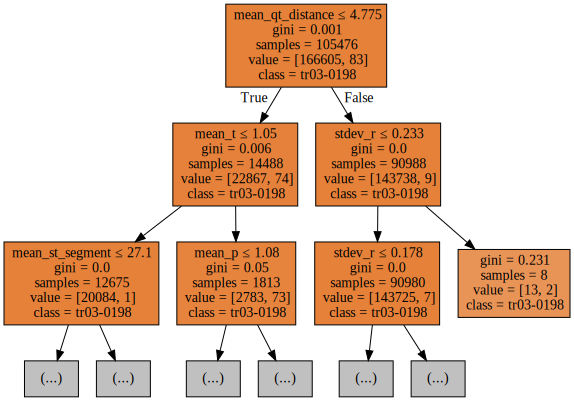

In [9]:
dot_data = tree.export_graphviz(ovr_step_4.estimators_[4].estimators_[4], out_file=None,
                                feature_names=X_step_4.columns, max_depth=2,
                                class_names=y_test_step_4.unique(),  
                                filled=True, special_characters=True)
graph = graphviz.Source(dot_data)
image_bytes = graph.pipe(format='eps')

# Save tree image on Google Drive
with open('trees_visualization.eps','wb') as picture_file:
    picture_file.write(image_bytes)

# Preview tree image o Colab
graph.render("trees_visualization") 
graph

## Checking model feature importance

In [ ]:
importances = [(feature, round(importance, 2)) for feature, importance in zip(X_step_4.columns, rf_step_4.feature_importances_)]
sorted_importances = sorted(importances, key=lambda x:x[1], reverse=True) 

for pair in sorted_importances:
    print('Feature: {:20} Importance: {}'.format(*pair))

In [ ]:
x_values = range(len(rf_step_4.feature_importances_))
plt.figure(figsize=(10,5))
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.xticks(x_values, X_step_4.columns, rotation='vertical')
plt.bar(x_values, rf_step_4.feature_importances_, orientation = 'vertical')